In [2]:
import torch
import math
class LayerTokenAnnealingLR(object):
    """Anneals the learning rate."""
    def __init__(self, max_lr, min_lr, decay_style,
                  total_consumed_token_layers=None,
                  lr_warmup_tokens=None,
                  depth=None):
        # Class values.
        self.max_lr = float(max_lr)
        self.min_lr = min_lr
        assert self.min_lr >= 0.0
        assert self.max_lr >= self.min_lr
        self.num_steps = 0

        self.num_tokens = 0
        self.warmup_tokens = lr_warmup_tokens
        self.decay_style = decay_style
    
        self.warmup_tokens = lr_warmup_tokens * depth # make it to token-layers
        self.decay_tokens = total_consumed_token_layers - self.warmup_tokens
        # Set the learning rate
        # self.step(0,self.num_tokens)
        # print('> learning rate decay style: {}'.format(self.decay_style))
        
    def get_lr(self):
        # reserved_factor = math.sqrt(reserved_length / 2048.0)
        reserved_factor = 1.0
        # Use linear warmup for the initial part.

        if self.warmup_tokens > 0 and self.num_tokens <= self.warmup_tokens:
            return self.max_lr * float(self.num_tokens) / \
                float(self.warmup_tokens) * reserved_factor
        # If the learning rate is constant, just return the initial value.
        if self.decay_style == 'constant':
            return self.max_lr
        # token-based decay
        if self.num_tokens > self.decay_tokens:
            return self.min_lr
        num_tokens_ = self.num_tokens - self.warmup_tokens
        decay_tokens_ = self.decay_tokens - self.warmup_tokens
        decay_ratio = float(num_tokens_) / float(decay_tokens_)

        assert decay_ratio >= 0.0
        assert decay_ratio <= 1.0
        delta_lr = self.max_lr - self.min_lr
        if self.decay_style == 'linear':
            coeff = (1.0 - decay_ratio)
        elif self.decay_style == 'cosine':
            coeff = 0.5 * (math.cos(math.pi * decay_ratio) + 1.0)
        else:
            raise Exception('{} decay style is not supported.'.format(
                self.decay_style))
       
        return (self.min_lr + coeff * delta_lr) * reserved_factor

    def step(self, token_num=None):
        self.num_tokens = token_num
        self.num_steps += 1
        new_lr = self.get_lr()


10682
0.9992611438762948
0.9999919786666667


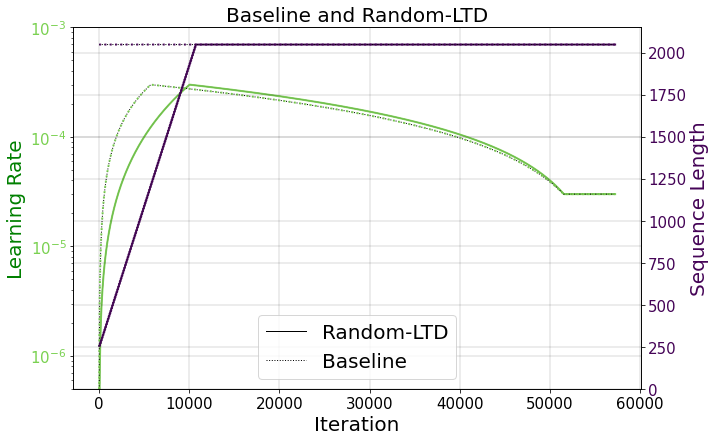

In [4]:
###########################################################GPT pretraining

# args_increse_length_token_interval = 0.25
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
fig,axs = plt.subplots(1,1,figsize=(int(1.3*8),int(1.3*6)),sharey=True)  
fig.tight_layout(pad=6.08, h_pad=0.1, w_pad=0.1)
ax1 = axs.twinx()
lrs = collections.defaultdict(list)
sequences = collections.defaultdict(list)
cmap = matplotlib.cm.get_cmap('viridis')
c3= cmap(0.45)
c2 = cmap(0.01)
c1 = cmap(0.8)
green = c1
blue=c2
pass_here=True
for args_increse_length_token_interval in [ 0.05, 0.]:
    args_train_tokens = 30000000000 ####42,034,887,004
    #warmup_token=420348870###420,348,870
    warmup_token=int(args_train_tokens*0.1)#208195315#300000000 2,099,806,770
    # args_train_tokens =30,000,000,000
    # warmup_token=300,000,000
    args_seq_length = 2048 #?==?128
    new_samples = 256
    total_iter = args_train_tokens//new_samples//args_seq_length
    ###### 16/(1e9*args_increse_length_token_inter)
    if args_increse_length_token_interval == 0:
        args_initial_sequence_length = 2048
        args_total_warmup_token_needed_tokendropping = 0
    else:
        args_initial_sequence_length = 256
        args_total_warmup_token_needed_tokendropping = (args_seq_length - args_initial_sequence_length) / 16 * args_increse_length_token_interval * 1e9
    args_total_consumed_token_layers = args_total_warmup_token_needed_tokendropping * 22 * (args_seq_length + args_initial_sequence_length) // 2 // args_seq_length \
        + args_total_warmup_token_needed_tokendropping * 2 + (args_train_tokens - args_total_warmup_token_needed_tokendropping) * 24
    args_consumed_token_layers = 0
    args_consumed_train_tokens = 0
    max_lr = 3e-4
    min_lr =3e-5
    scheduler = LayerTokenAnnealingLR(max_lr, min_lr, 'linear',
                  total_consumed_token_layers=args_total_consumed_token_layers,
                  lr_warmup_tokens=warmup_token,
                  depth=24)
    for iteration in range(total_iter):
        if args_increse_length_token_interval != 0:
            reserved_length = min( ((args_consumed_train_tokens / 1e9) // args_increse_length_token_interval) * 16 + args_initial_sequence_length, args_seq_length) # 240B 2048
        ##### 16/(1e9*args_increse_length_token_inter)
            if reserved_length==2048 and pass_here:
              print (iteration)
              import time
              time.sleep(10)
              pass_here=False
        else:
            reserved_length = args_seq_length

        args_consumed_token_layers += new_samples * args_seq_length * 2 + new_samples * reserved_length * 22 
        args_consumed_train_tokens += new_samples * args_seq_length
        scheduler.step(args_consumed_token_layers)
        lrs[args_increse_length_token_interval].append(scheduler.get_lr())
        sequences[args_increse_length_token_interval].append(reserved_length)
    print (args_consumed_token_layers/args_total_consumed_token_layers)
    if args_increse_length_token_interval != 0:
        ls = '-'
        label_name = "Random-LTD"
    else:
        label_name = "Baseline"
        ls = ':'
    axs.plot(lrs[args_increse_length_token_interval], color='black',  linewidth=1, linestyle=ls, label=label_name)
    ax1.plot(sequences[args_increse_length_token_interval], color='black',   linewidth=1, linestyle=ls, label=label_name) 

    axs.plot(lrs[args_increse_length_token_interval], color=green,  alpha=.9,linestyle=ls, linewidth=2)
    ax1.plot(sequences[args_increse_length_token_interval], color=blue,alpha=.9,  linestyle=ls, linewidth=2)  
    
# axs.legend() 
for label in (axs.get_yticklabels()):    
    label.set_fontname('Arial')
    label.set_fontsize(15) 
    label.set_color(green)
for label in (ax1.get_yticklabels()):    
    label.set_fontname('Arial')
    label.set_color(blue)
    label.set_fontsize(15)
for label in (ax1.get_xticklabels()):    
    label.set_fontname('Arial')
    label.set_fontsize(15)
for label in (axs.get_xticklabels()):    
    label.set_fontname('Arial')
    label.set_fontsize(15)  
    
axs.grid(color='black', linestyle=':', linewidth=0.38)
ax1.grid(color='black', linestyle=':', linewidth=0.38)
axs.set_xlabel('Iteration',fontsize = 20,)
ax1.legend(prop={'size': 20},loc='lower center' )
ax1.set_ylim([0,2150])
axs.set_yscale('log')
axs.set_ylim([5e-7,1e-3])

ax1.set_title('Baseline and Random-LTD',fontsize = 20,)
ax1.set_ylabel('Sequence Length', color=blue, fontsize = 20,)
axs.set_ylabel('Learning Rate', color='green', fontsize = 20,)
fig.savefig('GPT.pdf')




10000
38 ===================> 1739502
38 0.9822297556606392 1.0971257922988315e-05 0.31143425
0 ===================> 0
0 1.0000005 1e-05 -5.00000000069889e-07


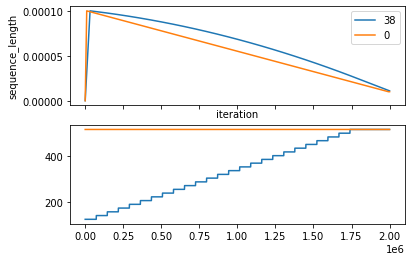

: 

In [11]:

task_name='bert'
dropout = 0.0
###########################################################BERT pretraining
# args_increse_length_token_interval = 0.25
import collections
import matplotlib.pyplot as plt
import numpy as np
f, axs = plt.subplots(2,1 , sharex=True)
lrs = collections.defaultdict(list)
sequences = collections.defaultdict(list)

args_initial_sequence_length1 = 128
args_seq_length = 512 #?==?128
new_samples = 1024
iterations = 2*1e6

original_tokens = new_samples*args_seq_length*iterations*24
args_train_tokens = int(1.0*1024*512*iterations) 
#warmup_token=420348870###420,348,870
warmupiterations = 10000 #iterations*0.01
print (warmupiterations)
warmup_token= int(1024*512*warmupiterations) #208195315#300000000 2,099,806,770
# args_train_tokens =30,000,000,000
# warmup_token=300,000,000
max_lr = 1e-4
min_lr = 1.e-5

for args_increse_length_token_interval in [38,0]:#:32,16,0]:#:8, 6.0, 3.8, 2.0]:
    if args_increse_length_token_interval==0:
        args_initial_sequence_length = args_seq_length
    else:
        args_initial_sequence_length = args_initial_sequence_length1
        reserved_length  = args_initial_sequence_length1

    args_total_warmup_token_needed_tokendropping = (args_seq_length - args_initial_sequence_length) / 16 * args_increse_length_token_interval * 1e9
    args_total_consumed_token_layers = args_total_warmup_token_needed_tokendropping * 22 * (args_seq_length + args_initial_sequence_length) // 2 // args_seq_length \
        + args_total_warmup_token_needed_tokendropping * 2 + (args_train_tokens - args_total_warmup_token_needed_tokendropping) * 24
    args_consumed_token_layers = new_samples * args_seq_length * 2 + new_samples * reserved_length * 22 
    args_consumed_train_tokens = 0
    
    scheduler = LayerTokenAnnealingLR(max_lr, min_lr, 'linear',
                  total_consumed_token_layers=args_total_consumed_token_layers,
                  lr_warmup_tokens=warmup_token,
                  depth=24)
    pass_token = True
    for iteration in range(int(iterations)):
        if args_increse_length_token_interval!=0:
            reserved_length = min( ((args_consumed_train_tokens / 1e9) // args_increse_length_token_interval) * 16 + args_initial_sequence_length, args_seq_length) # 240B 2048
        else:
            reserved_length = args_seq_length
        if reserved_length==512 and pass_token:
            print (args_increse_length_token_interval,"===================>",iteration)
            pass_token=False
        args_consumed_token_layers += new_samples * args_seq_length * 2 + new_samples * reserved_length * 22 
        args_consumed_train_tokens += new_samples * args_seq_length
        scheduler.step(args_consumed_token_layers)
        lrs[args_increse_length_token_interval].append(scheduler.get_lr())
        sequences[args_increse_length_token_interval].append(reserved_length)
    print (args_increse_length_token_interval, args_consumed_token_layers/args_total_consumed_token_layers, scheduler.get_lr(), 1-args_consumed_token_layers/original_tokens)
    axs[0].plot(lrs[args_increse_length_token_interval], label=str(args_increse_length_token_interval))
    axs[1].plot(sequences[args_increse_length_token_interval], label=str(args_increse_length_token_interval))  
axs[0].legend()   
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('sequence_length')
       
fig.savefig(f'check_training_{task_name}_{dropout}.pdf') 

